In [1]:
import numpy as np
import pandas as pd
import os
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from google.colab import drive
from datetime import datetime

In [2]:
drive.mount('/content/drive')
root_path = 'drive/My Drive/KU/Robin_lab_project' 
os.chdir(root_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data exploration

In [3]:
# Load data 
profiles_all = pd.read_csv("Data/ML_input/profiles_replicate1_b2.csv")
metadata_all = pd.read_csv("Data/ML_input/metadata_replicate1_b2.csv")

X = profiles_all.drop("label", axis=1)
X = StandardScaler().fit_transform(X)
y = profiles_all["label"]

print(X.shape)
print(y.shape)

(13916, 1002)
(13916,)


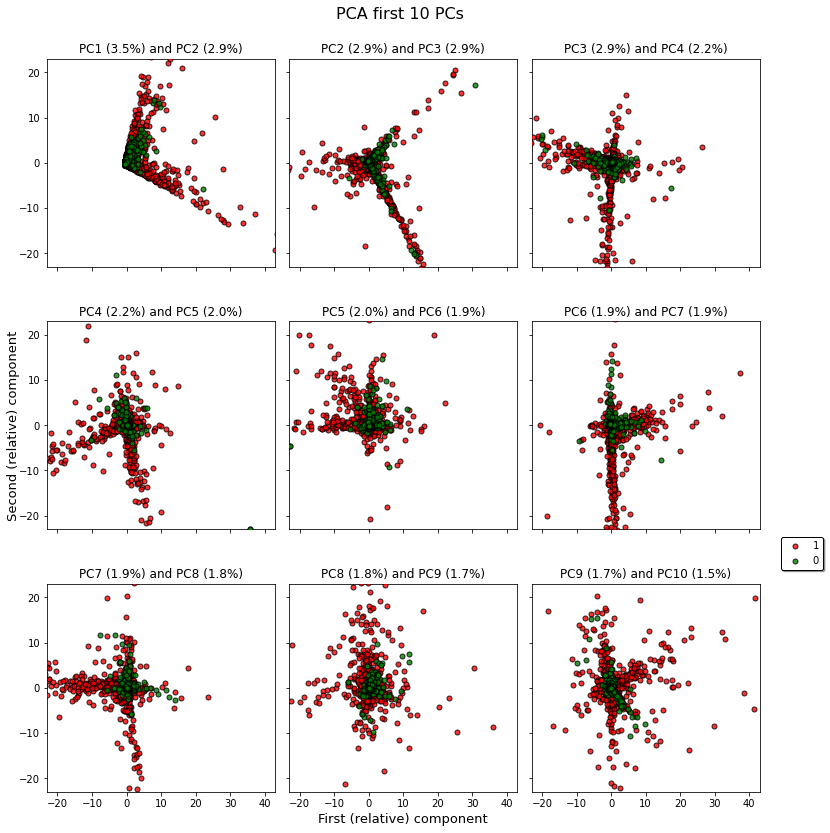

In [4]:
#  PCA plot
def multi_plot_pca(x, y, 
                   nrows=2, xlim=(-23,43), ylim=(-23,23),
                   figsize=(12,7), top=0.89,
                   title="", save=False, filename="pca"):
  # Perform PCA and MDS
  n_pcs = nrows*3+1
  pca = PCA(n_components=n_pcs)
  pcs = pca.fit_transform(x)
  var = pca.explained_variance_ratio_ * 100
  tmp_df = pd.concat([pd.DataFrame(pcs), y], axis = 1)
  targets = [1,0]
  colors = ["r","g"]
  # Plot fig and axes
  fig, axes = plt.subplots(nrows, 3, figsize = figsize, sharex=True, sharey=True)
  fig.add_subplot(111, frameon=False)
  for target, color in zip(targets,colors):
    i_keep = tmp_df['label'] == target
    for i ,ax in enumerate(axes.flatten()):
      ax.scatter(tmp_df.loc[i_keep,i], tmp_df.loc[i_keep,i+1], zorder=3, 
                      ec="black", c=color, s=25, alpha = 0.8, label = target) 
      ax.set_title(f"PC{i+1} ({var[i]:.2}%) and PC{i+2} ({var[i+1]:.2}%)")
      ax.set_xlim(xlim)
      ax.set_ylim(ylim)
  # Details
  legend = ax.legend(frameon = 1, shadow = True, bbox_to_anchor=(1.3, 1.25))
  frame = legend.get_frame()
  frame.set_facecolor('white')
  frame.set_edgecolor('black')
  plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
  fig.suptitle(f"PCA first {n_pcs} PCs{title}", fontsize=16)
  plt.xlabel("First (relative) component", fontsize=13)
  plt.ylabel("Second (relative) component", fontsize=13)
  fig.tight_layout()
  fig.subplots_adjust(top=top)
  if save == True:
      plt.savefig(filename + ".png", dpi = 300)
  plt.show()

multi_plot_pca(X, y, nrows=3, figsize=(12,12), top=0.92, 
               save=True, filename="Plots/pca_multiplot_allchr_1replicate_b2_min2filtered")     

# Models development

### Split train and test by chromosomes number

In [5]:
# Load data divded by chr number
profiles_train = pd.read_csv("Data/ML_input/profiles_replicate1_b2_train.csv")
profiles_test = pd.read_csv("Data/ML_input/profiles_replicate1_b2_test.csv")
metadata_train = pd.read_csv("Data/ML_input/metadata_replicate1_b2_train.csv")
metadata_test = pd.read_csv("Data/ML_input/metadata_replicate1_b2_test.csv")

# Divide predictor and target
X_train = profiles_train.drop("label", axis = 1)
y_train = profiles_train["label"]
X_test = profiles_test.drop("label", axis = 1)
y_test = profiles_test["label"]

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(11417, 1002)
(11417,)
(2499, 1002)
(2499,)


In [44]:
def get_accuracy(ypred, y):
  return sum(ypred == y) / len(y)

def rmse(yprob, y):
  return np.sqrt(np.mean((yprob-y)**2))

(0.4027365225179316, 0.39083493367166255, 0.5054897302998571)

#### Randomly split train and test keeping label proportion

In [7]:
# # Split data randomly by chr proportion
# sss = StratifiedShuffleSplit(y, n_splits=10, test_size=0.2, random_state=23)

# for itrain, itest in sss:
#     X_train, X_test = X[itrain], X[itest]
#     y_train, y_test = y[itrain], y[itest]

## Random forest

In [8]:
def rf_train_pred(xtrain, ytrain, xtest, ytest, n_tree=100, name="RF"):
  start_time = datetime.now()
  # Train
  model = RandomForestClassifier(n_estimators=n_tree, bootstrap=True)
  model.fit(xtrain, ytrain)
  # Predict
  ytrain_pred = model.predict(xtrain)
  ytrain_prob = model.predict_proba(xtrain)[:,1]
  ytest_pred = model.predict(xtest)
  ytest_prob = model.predict_proba(xtest)[:,1]
  # Evaluate
  train_accuracy = get_accuracy(ytrain_pred, ytrain)
  test_accuracy = get_accuracy(ytest_pred, ytest)
  print(f"{name} train accuracy: {train_accuracy}")
  print(f"{name} test accuracy: {test_accuracy}")
  # Report time 
  end_time = datetime.now()
  print(f"Duration: {end_time - start_time}")
  return test_accuracy, model, ytest_prob, ytest_pred

rf_acc, rf_model, rf_yprob, rf_ypred = rf_train_pred(X_train, y_train, X_test, y_test)

RF train accuracy: 0.9706577910134011
RF test accuracy: 0.767907162865146
Duration: 0:00:57.386682


## LightGBM    
### >> Should validate on validation data <<
Should split train into training and validation keeping both labels and chr proportion 

In [9]:
def lgb_train_pred(xtrain, ytrain, xtest, ytest, par, name="LGBM"):
  start_time = datetime.now()
  # Train
  train_data = lgb.Dataset(xtrain , label = ytrain)
  valid_data = lgb.Dataset(xtest, label = ytest)
  model = lgb.train(par, train_data, valid_sets=[valid_data], verbose_eval=20) 
  # Predict
  ytrain_prob = model.predict(np.array(xtrain))
  ytrain_pred = np.round(ytrain_prob)
  ytest_prob = model.predict(np.array(xtest))
  ytest_pred = np.round(ytest_prob)
  # Evaluate
  train_accuracy = get_accuracy(ytrain_pred, ytrain)
  test_accuracy = get_accuracy(ytest_pred, ytest)
  print(f"{name} train accuracy: {train_accuracy}")
  print(f"{name} test accuracy: {test_accuracy}")
  # Report time 
  end_time = datetime.now()
  print(f"Duration: {end_time - start_time}")
  return test_accuracy, model, ytest_prob, ytest_pred

params = {"application" : "binary",
          "num_boost_round" : 400,
         # "metric" :"binary_logloss",
          "metric" :"rmse",
          "force_row_wise" : True,
          "learning_rate" : 0.009,
         # "sub_feature" : 0.8,
         # "sub_row" : 0.75,
         # "bagging_freq" : 1,
         # "lambda_l2" : 0.1,
         # 'verbosity': 1,
          'num_iterations' : 12000
         # 'num_leaves': 128,
         # "min_data_in_leaf": 100,
}

lgb_acc, lgb_model, lgb_yprob, lgb_ypred = lgb_train_pred(X_train, y_train, X_test, y_test, params)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's rmse: 0.49058
[40]	valid_0's rmse: 0.483074
[60]	valid_0's rmse: 0.476659
[80]	valid_0's rmse: 0.471313
[100]	valid_0's rmse: 0.466923
[120]	valid_0's rmse: 0.46323
[140]	valid_0's rmse: 0.460029
[160]	valid_0's rmse: 0.457359
[180]	valid_0's rmse: 0.45505
[200]	valid_0's rmse: 0.452984
[220]	valid_0's rmse: 0.451164
[240]	valid_0's rmse: 0.449445
[260]	valid_0's rmse: 0.447968
[280]	valid_0's rmse: 0.44655
[300]	valid_0's rmse: 0.445296
[320]	valid_0's rmse: 0.444109
[340]	valid_0's rmse: 0.442968
[360]	valid_0's rmse: 0.441936
[380]	valid_0's rmse: 0.441089
[400]	valid_0's rmse: 0.440249
[420]	valid_0's rmse: 0.43935
[440]	valid_0's rmse: 0.438691
[460]	valid_0's rmse: 0.437907
[480]	valid_0's rmse: 0.437189
[500]	valid_0's rmse: 0.436482
[520]	valid_0's rmse: 0.435807
[540]	valid_0's rmse: 0.435134
[560]	valid_0's rmse: 0.434548
[580]	valid_0's rmse: 0.433899
[600]	valid_0's rmse: 0.433325
[620]	valid_0's rmse: 0.432746
[640]	valid_0's rmse: 0.432186
[660]	valid_0's r

In [10]:
# # LGBM Feature importance
# plt.rcParams['figure.figsize'] = (18.0, 4)
# fig, ax = plt.subplots(figsize=(12,8))
# lgb.plot_importance(lgb_model, max_num_features=50, height=0.8, ax=ax)
# ax.grid(False)
# plt.title("LightGBM - Feature Importance ", fontsize=15)

## SVM

In [11]:
def svm_train_pred(xtrain, ytrain, xtest, ytest, model, name="SVM"):
  start_time = datetime.now()
  # Train and predict
  model = model.fit(xtrain, ytrain)
  ytrain_prob = model.predict(xtrain)
  ytest_prob = model.predict(xtest)
  ytrain_pred = np.round(ytrain_prob)
  ytest_pred = np.round(ytest_prob)
  # Evaluate
  train_accuracy = get_accuracy(ytrain_pred, ytrain)
  test_accuracy = get_accuracy(ytest_pred, ytest)
  print(f"{name} train accuracy: {train_accuracy}")
  print(f"{name} test accuracy: {test_accuracy}")
  # Report time 
  end_time = datetime.now()
  print(f"Duration: {end_time - start_time}")
  return test_accuracy, model, ytest_prob, ytest_pred

svr_rbf = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1) # acc 0.68, AUC 0.792
# svr_rbf = svm.SVR(kernel='rbf') # acc 0.57, AUC 0.7
svm_acc, svm_model, svm_yprob, svm_ypred = svm_train_pred(X_train, y_train, X_test, y_test, model=svr_rbf)

SVM train accuracy: 0.9151265656477183
SVM test accuracy: 0.6914765906362546
Duration: 0:12:58.279523


## Performance evaluation

In [16]:
# Function to quickly add plot details
def plot_details(title = "", xlabel = "X-axis", ylabel = "Y-axis",
                 ax_equal = False, legend = True, leg_loc = None,
                 grid = True, save = False, filename = False):
    # Title and axis
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    if ax_equal == True:
        plt.axis('equal') 
    # Legend and grid
    if legend == True:
        legend = plt.legend(frameon = 1, loc = leg_loc, shadow = True)
        frame = legend.get_frame()
        frame.set_facecolor('white')
        frame.set_edgecolor('black')
    if grid == True:
        plt.grid(zorder=0, color="lightgray")
    # Output
    if save == True:
        plt.savefig(filename + ".png", dpi = 300)
    plt.show()

#### Classification report

In [17]:
print("Random forest:\n", classification_report(y_test, rf_ypred))
print("LightGBM:\n",classification_report(y_test, lgb_ypred))
print("SVM RBF:\n",classification_report(y_test, svm_ypred))

Random forest:
               precision    recall  f1-score   support

           0       0.75      0.83      0.78      1277
           1       0.80      0.71      0.75      1222

    accuracy                           0.77      2499
   macro avg       0.77      0.77      0.77      2499
weighted avg       0.77      0.77      0.77      2499

LightGBM:
               precision    recall  f1-score   support

           0       0.79      0.84      0.81      1277
           1       0.82      0.77      0.79      1222

    accuracy                           0.80      2499
   macro avg       0.81      0.80      0.80      2499
weighted avg       0.81      0.80      0.80      2499

SVM RBF:
               precision    recall  f1-score   support

         0.0       0.71      0.78      0.74      1277
         1.0       0.73      0.60      0.66      1222
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### ROC

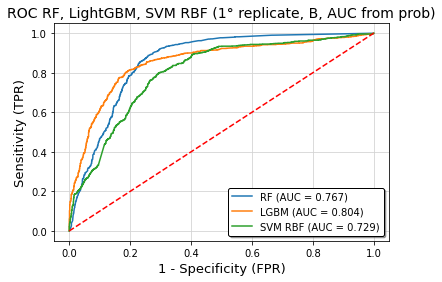

In [49]:
# Compute FPR and TPR
rf_roc_auc = roc_auc_score(y_test, rf_ypred)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_yprob)
lgb_roc_auc = roc_auc_score(y_test, lgb_ypred)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, lgb_yprob)
svm_roc_auc = roc_auc_score(y_test, svm_ypred)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_yprob)

# Plot ROC
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.plot(fpr_rf, tpr_rf, label=f"RF (AUC = {rf_roc_auc:.3})")
ax.plot(fpr_lgb, tpr_lgb, label=f"LGBM (AUC = {lgb_roc_auc:.3})")
ax.plot(fpr_svm, tpr_svm, label=f"SVM RBF (AUC = {svm_roc_auc:.3})")
ax.plot([0, 1], [0, 1],'r--')
plot_details(title = "ROC RF, LightGBM, SVM RBF (1° replicate, B, AUC from prob)",
             xlabel = '1 - Specificity (FPR)', 
             ylabel = 'Sensitivity (TPR)',
             leg_loc = "lower right",
             save = True,
             filename = "Plots/roc_rf_lgbm_replicate1_b2")

#### Plot some metrics

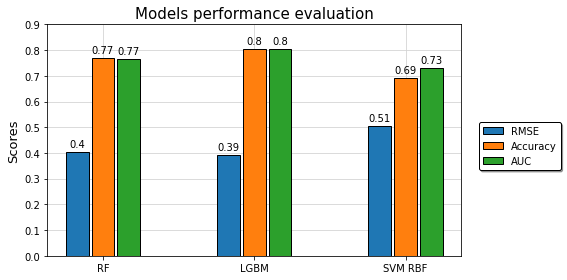

In [144]:
def autolabel(rects, xpos='center'):
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f"{height:.2}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')
        
# Plot some metrics
acc = rf_acc, lgb_acc, svm_acc
rmse = rf_rmse, lgb_rmse, svm_rmse
auc = rf_roc_auc, lgb_roc_auc, svm_roc_auc
labels = ('RF', 'LGBM', 'SVM RBF')

n = len(acc)
x = np.arange(n)  # the x locations for the groups
w = 0.17          # the width of the bars

fig, ax = plt.subplots(figsize=(8,4))
rects1 = ax.bar(x + (w*(1-n)/2) + 0*w, rmse, width, label='RMSE', zorder=3, 
                      ec="black")
rects2 = ax.bar(x + (w*(1-n)/2) + 1*w, acc, width, label='Accuracy', zorder=3, 
                      ec="black")
rects3 = ax.bar(x + (w*(1-n)/2) + 2*w, auc, width, label='AUC', zorder=3, 
                      ec="black")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores', fontsize = 13)
ax.set_title('Models performance evaluation', fontsize = 15)
ax.set_ylim(0,0.9)
ax.set_xticks(ind)
ax.set_xticklabels(('RF', 'LGBM', 'SVM RBF'))
legend = ax.legend(frameon = 1, shadow = True, bbox_to_anchor=(1.03, 0.6))
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
ax.grid(zorder=0, color="lightgray")        
autolabel(rects1, "center")
autolabel(rects2, "center")
autolabel(rects3, "center")
fig.tight_layout()
plt.savefig("Plots/models_performance_replicate1_b.png", dpi = 300)
plt.show()